In [42]:
# %load jupyter_default.py
import pandas as pd
import numpy as np
import os
import re
import datetime
import time
import glob
from tqdm import tqdm_notebook
from colorama import Fore, Style

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['legend.fancybox'] = True
plt.style.use('ggplot')

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 14, 16, 20
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

def savefig(plt, name):
    plt.savefig(f'../../figures/{name}.png', bbox_inches='tight', dpi=300)

%load_ext version_information
%version_information pandas, numpy

from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;}</style>')

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


In [43]:
%reload_ext version_information
%version_information pandas, numpy

Software versions
Python 3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.2.0
OS Darwin 18.2.0 x86_64 i386 64bit
pandas 0.23.4
numpy 1.15.4
Sun Mar 03 21:00:49 2019 PST

# Goalie Pull Bayes Optimize

 - Solve for the posterior probabilties at time t:    
$
P(\text{goal for}|\text{goalie pulled}; t)\\
P(\text{goal against}|\text{goalie pulled}; t)
$

The idea is to figure out the **risk reward of pulling a goalie as a function of:**
 - **t = Time remaining in the game.** For instance, if there's 3 minutes left, what is the chance that pulling the goalie will result in a goal for? What is the probability it will result in a goal against?
 - **t = Time since goalie pull.** For instance, after the goalie has been pulled for 1 minute, what is the chance of seeing a goal for or goal against?
 
We'll model these independently.

Another complication is that games can end without either team scoring. To handle this we could correct our calculated posteriors based on the fraction of games that end this way. Or, better yet, we can calculate $P(\text{game end}|\text{goalie pulled}; t)$ in our model as well.

## Train Bayesian Model

We can model $P(t)$ using a discrete **poisson distribution i.e. if modeling the probability by second. We could also assume a Gamma posterior for the continuous case.**

We'll solve for this posterior distribution computationally using markov chain monte carlo and the `pymc3` library. 

Ideally we could use a **uniform prior over the domain of times (last 5mins)**. Note: this is OK since we throw out goalie pulls greater than 5 minutes from the end of the game (due to high likelihood of false positives when parsing goalie pulls from the raw game table).

In [5]:
import pymc3 as pm

### Load the training data

In [6]:
def load_data():
    files = glob.glob('../../data/processed/pkl/*.pkl')
    files = sorted(files)
    print(files)
    return pd.concat((pd.read_pickle(f) for f in files))

def clean_df(df):
    _df = df.copy()
    
    len_0 = _df.shape[0]
    print('Removing goal_for_time < 15 mins')
    _df = _df[~(_df.goal_for_time < datetime.timedelta(seconds=15*60))]
    print(f'Removed {len_0 - _df.shape[0]} total rows')
    
    if 'game_end_time' in df.columns:
        len_0 = _df.shape[0]
        print('Removing game_end_time < 15 mins')
        _df = _df[~(_df.game_end_time < datetime.timedelta(seconds=60*15))]
        print(f'Removed {len_0 - _df.shape[0]} total rows')

    return _df

In [7]:
df = load_data()
df = clean_df(df)

['../../data/processed/pkl/20032004_goalie_pulls_2019-03-01.pkl', '../../data/processed/pkl/20052006_goalie_pulls_2019-03-01.pkl', '../../data/processed/pkl/20062007_goalie_pulls_2019-03-01.pkl']
Removing goal_for_time < 15 mins
Removed 1 total rows


### Rough work

#### Data loading

In [77]:
def load_training_samples(
    df,
    cols,
    masks=[],
    dtype='timedelta64[s]'
) -> np.ndarray:
    '''
    Return buckets of training data.
    '''
    if not masks:
        masks = [None] * len(cols)
    out = []
    for col, m in zip(cols, masks):
        if m is None:
            d = df[col].dropna().astype(dtype).values
        else:
            d = df[col][m].dropna().astype(dtype).values
        out.append(d)
        print(f'Loaded {len(d)} samples for col {col}')

    out = np.array(out)
    print(f'Training data shape = {out.shape}')
    return out

Let's start by modeling the 5 on 6 goal times in 3rd period, where time is a continuous (or rather, discretized by second) and measured in minutes.

In [75]:
features = ['goal_for_time', 'goal_against_time']
training_samples = load_training_samples(df, features)

Loaded 270 samples for col goal_for_time
Loaded 554 samples for col goal_against_time
shape = (2,)


In [46]:
training_samples[0].shape

(270,)

In [47]:
training_samples[0][:10]

array([1180., 1124., 1157., 1168., 1118., 1183., 1130., 1116., 1172.,
       1181.])

To get the proper probabilities, we should weight the 

#### Modeling

In [48]:
# with pm.Model() as model:
#     prior_goal_for = pm.Uniform('prior_goal_for', 15, 20)
#     prior_goal_against = pm.Uniform('prior_goal_against', 15, 20)
#     obs_goal_for = pm.Gamma('obs_goal_for', observed=training_samples[0])

# need to set up priors for all the parameters of the gamma!...
# THINK ABOUT IT

In [60]:
from scipy.stats import poisson

In [61]:
poisson?

```
pmf(k, mu, loc=0)   
    Probability mass function.
```

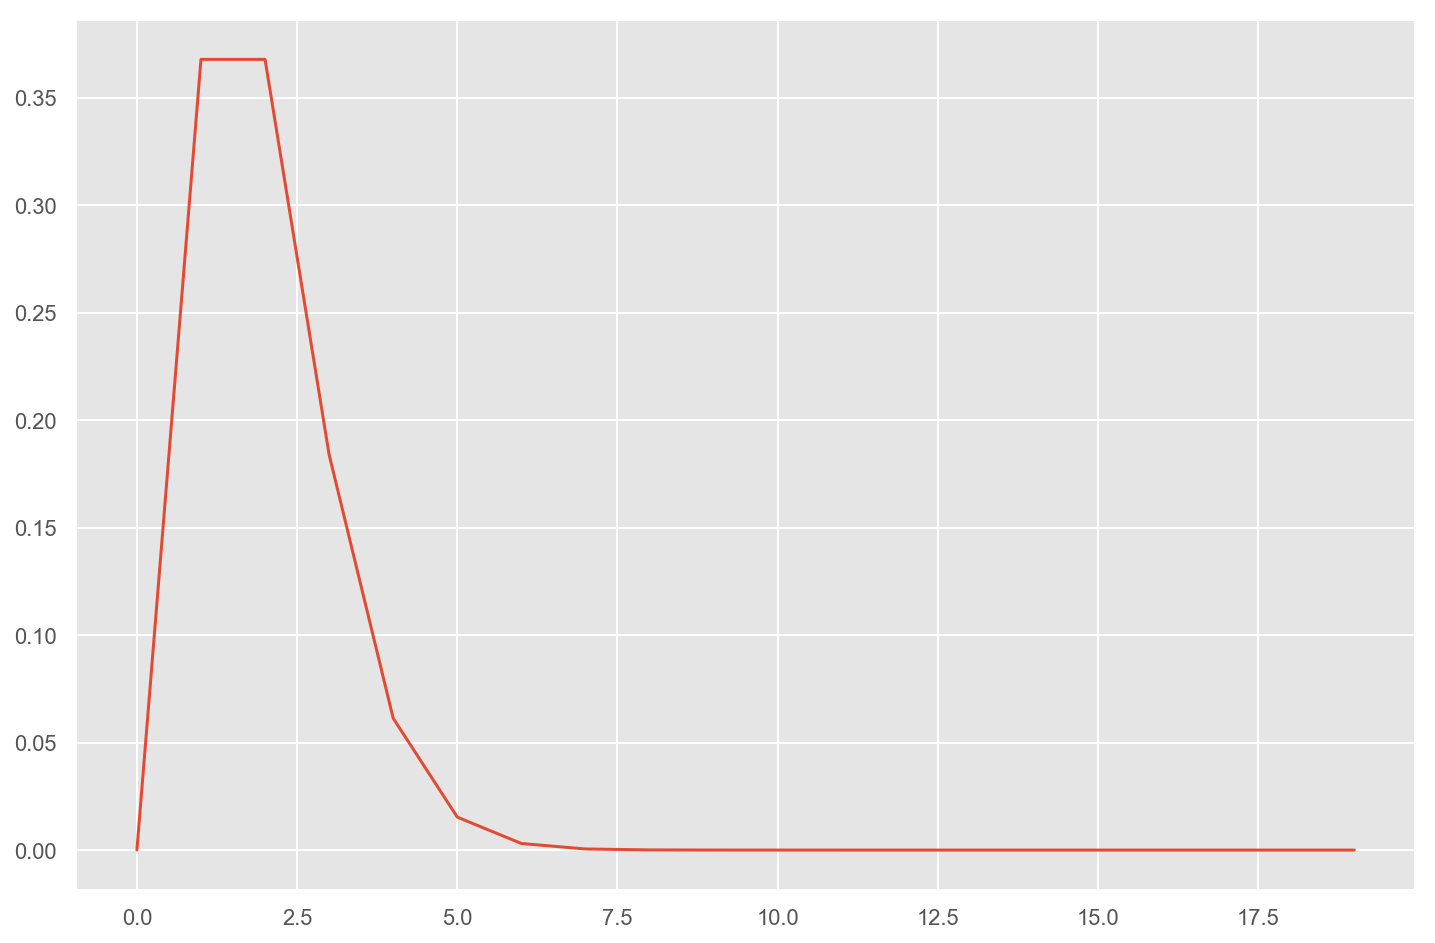

In [63]:
x = np.arange(0, 20, 1)
y = [poisson.pmf(_x, 1, 1)
     for _x in x]
plt.plot(x, y)

In [49]:
def bayes_model(training_samples):
    
    with pm.Model() as model:

        # Priors for the mu parameter of the poisson distribution
        # Note that mu = mean(Poisson)
        mu_goal_for = pm.Uniform('mu_goal_for', 15*60, 20*60)
        mu_goal_against = pm.Uniform('mu_goal_against', 15*60, 20*60)

        # Observations
        obs_goal_for = pm.Poisson('obs_goal_for', mu_goal_for, observed=training_samples[0])
        obs_goal_against = pm.Poisson('obs_goal_against', mu_goal_against, observed=training_samples[1])
        
        # Priors for the goal probabilities
        p_goal_for = pm.Poisson('p_goal_for', mu_goal_for)
        p_goal_against = pm.Poisson('p_goal_against', mu_goal_against)

        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

# N = 10
# test_training_samples = np.array([training_samples[0][:N],
#                                   training_samples[1][:N]])
# model, trace, burned_trace = bayes_model(test_training_samples)
# model

In [50]:
model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_goal_against]
>Metropolis: [p_goal_for]
>Metropolis: [mu_goal_against]
>Metropolis: [mu_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:19<00:00, 3839.72draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [51]:
N_burn = 10000
burned_trace = trace[N_burn:]

In [52]:
pm.plots.traceplot?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1ebe9e48>,
      dtype=object)

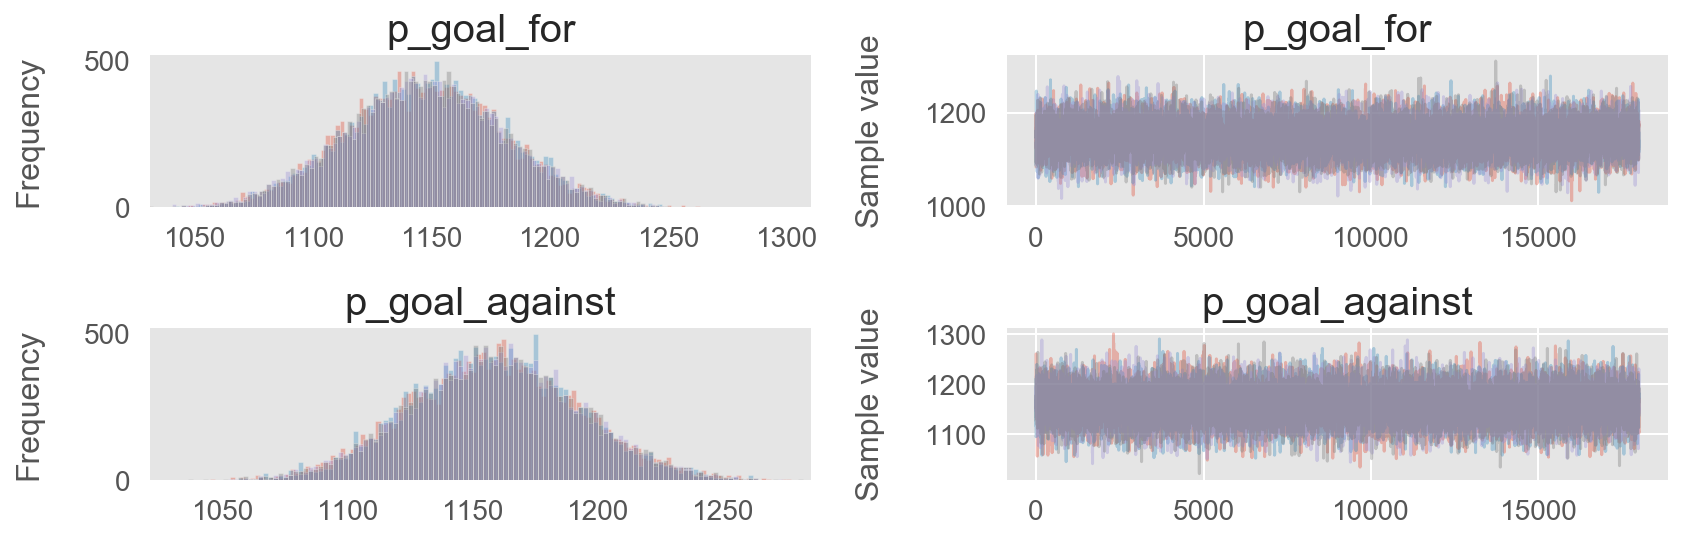

In [53]:
pm.plots.traceplot(trace=trace, varnames=['p_goal_for', 'p_goal_against'])

What do red and blue represent? 

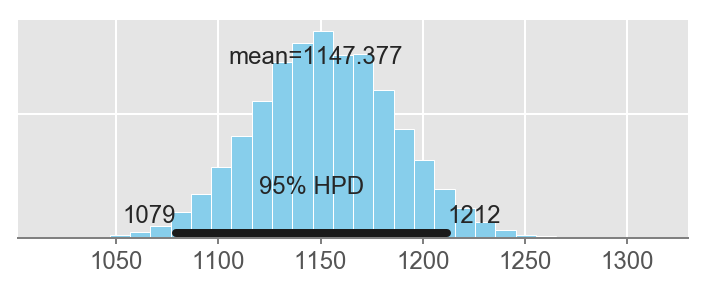

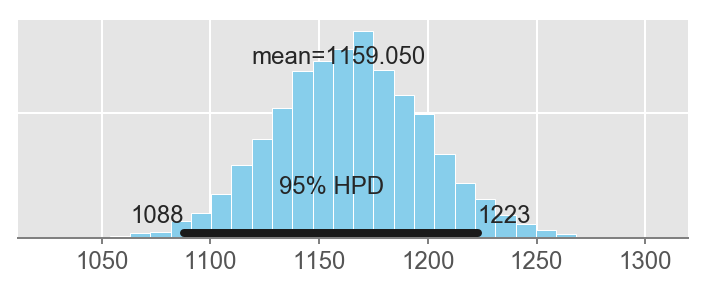

In [60]:
pm.plots.plot_posterior(trace=trace['p_goal_for'])
pm.plots.plot_posterior(trace=trace['p_goal_against'])

The HDR is really interesting! For the above case (normally distributed data), the HDR is pretty much equivalent to the SD based confience interval. However it generalizes to more complicated distributions 

https://stats.stackexchange.com/questions/148439/what-is-a-highest-density-region-hdr
e.g. 

![](https://i.stack.imgur.com/Dy89t.png)

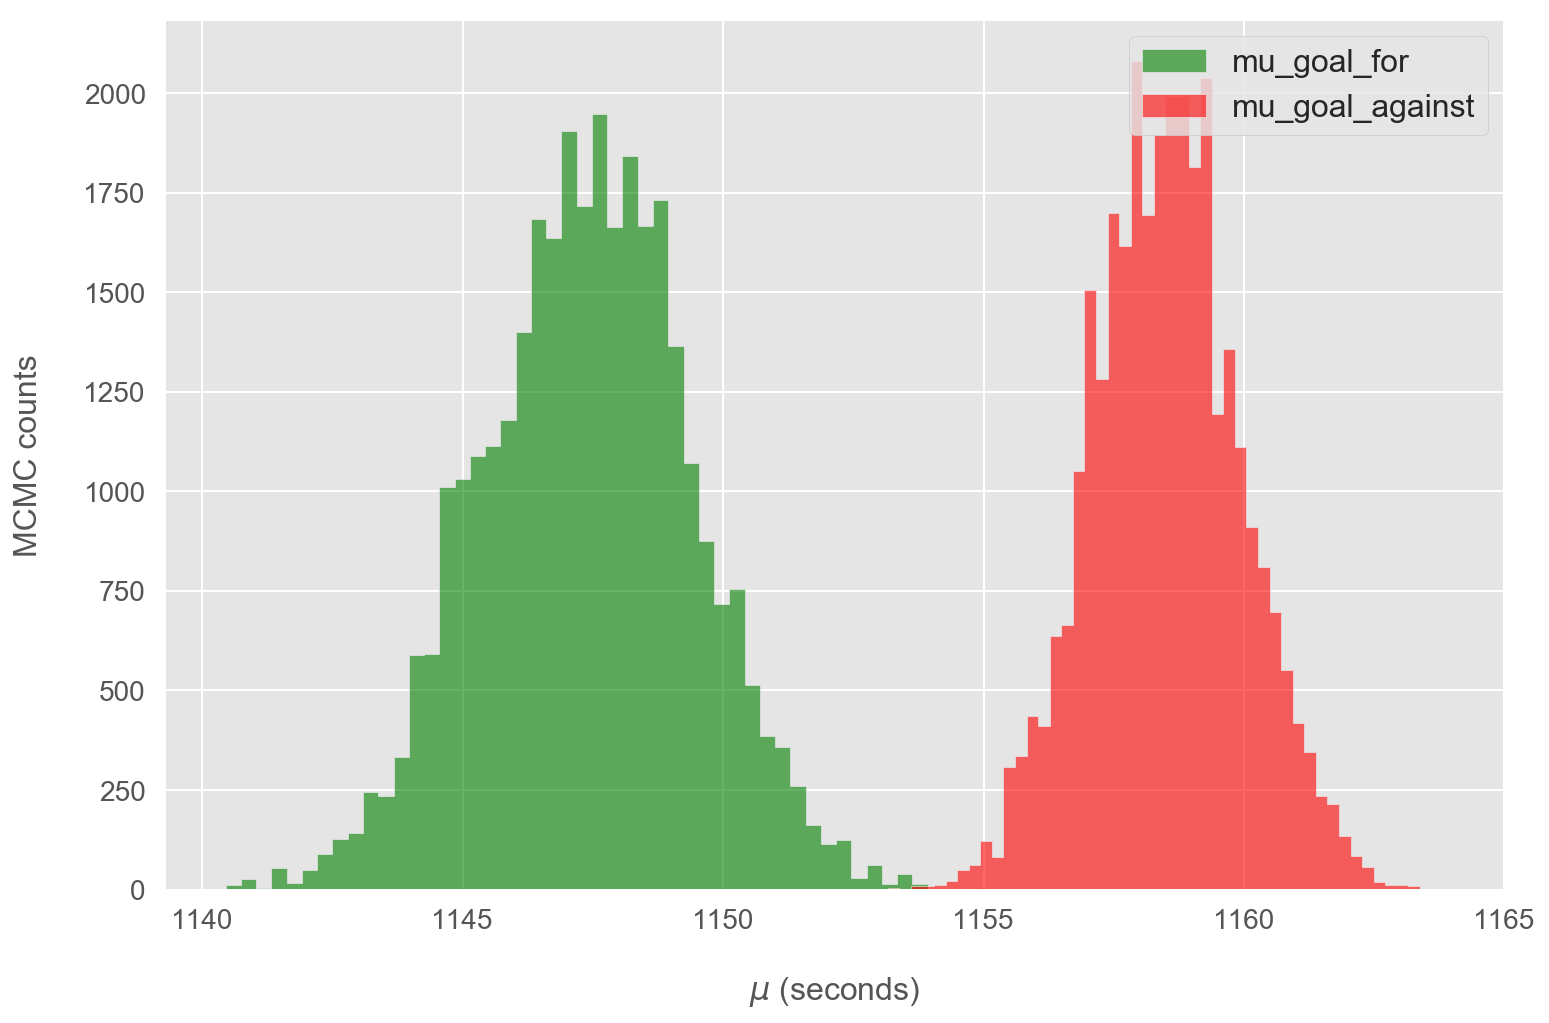

In [62]:
ALPHA = 0.6

plt.hist(burned_trace['mu_goal_for'], bins=50,
         color='green', label='mu_goal_for',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_goal_against'], bins=50,
         color='red', label='mu_goal_against',
         histtype='stepfilled', alpha=ALPHA)
plt.ylabel('MCMC counts')
plt.xlabel('$\mu$ (seconds)')
plt.legend();

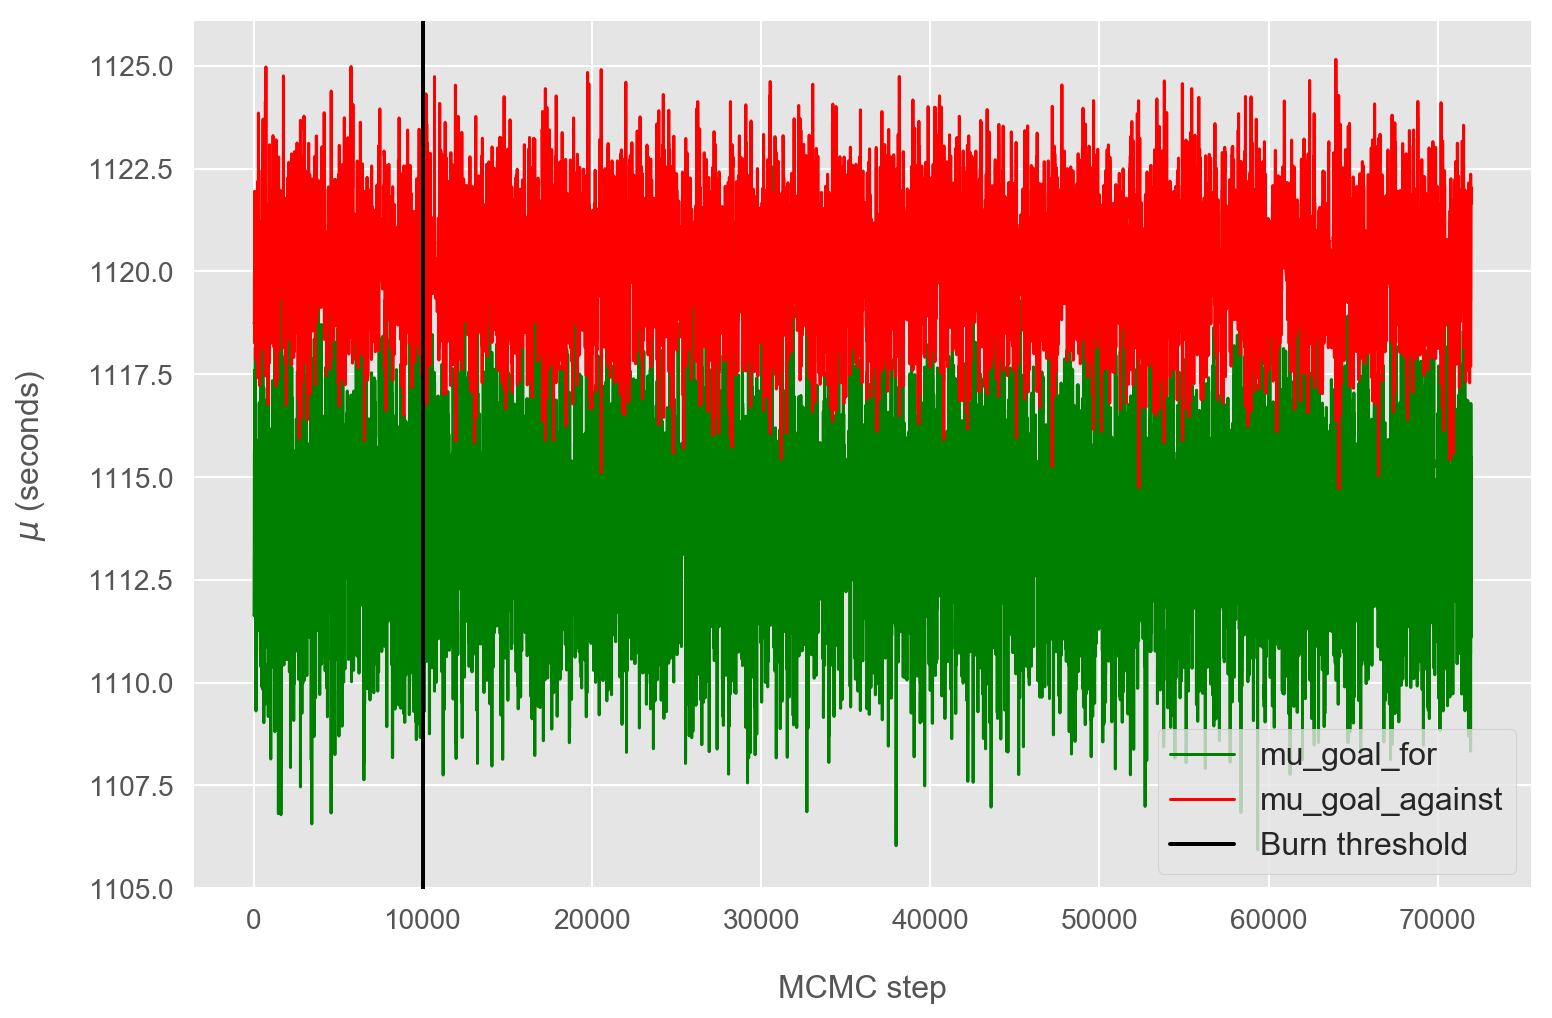

In [88]:
plt.plot(trace['mu_goal_for'], label='mu_goal_for', color='green')
plt.plot(trace['mu_goal_against'], label='mu_goal_against', color='red')
plt.ylabel('$\mu$ (seconds)')
plt.xlabel('MCMC step')

plt.axvline(N_burn, color='black', lw=2, label='Burn threshold')

plt.legend();

Include both those plots in blog ^

In [64]:
from scipy.special import factorial
poisson = lambda mu, k: mu**k * np.exp(-mu) / factorial(k)
poisson(0.5, np.array([1, 4, 5, 2]))

array([3.03265330e-01, 1.57950693e-03, 1.57950693e-04, 7.58163325e-02])

In [65]:
from scipy.stats import poisson

In [66]:
poisson.pmf?

In [67]:
poisson.pmf(3, 1)

0.06131324019524039

In [68]:
poisson.pmf(np.array([1, 4, 3]), 1)

array([0.36787944, 0.01532831, 0.06131324])

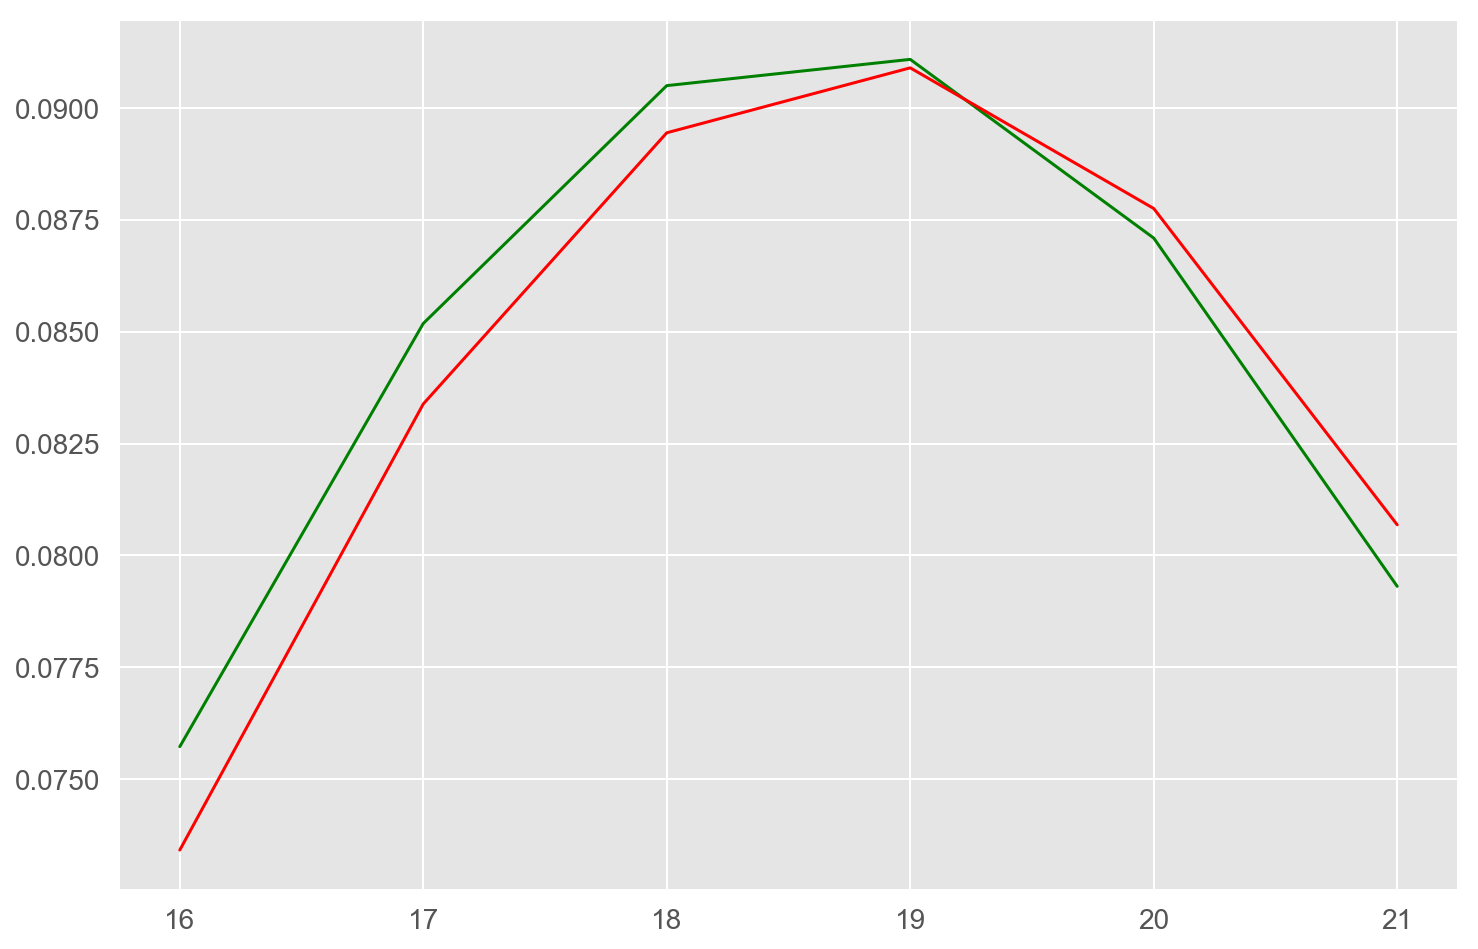

In [69]:
p = poisson.pmf
# poisson = lambda k, mu: mu**k * np.exp(-mu) / factorial(k)

x = np.arange(16, 22, 1)

mu_goal_for = burned_trace['mu_goal_for'].mean() / 60
y_goal_for = p(x, mu_goal_for)

mu_goal_against = burned_trace['mu_goal_against'].mean() / 60
y_goal_against = p(x, mu_goal_against)

plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{avg})$', color='green')
plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{avg})$', color='red')

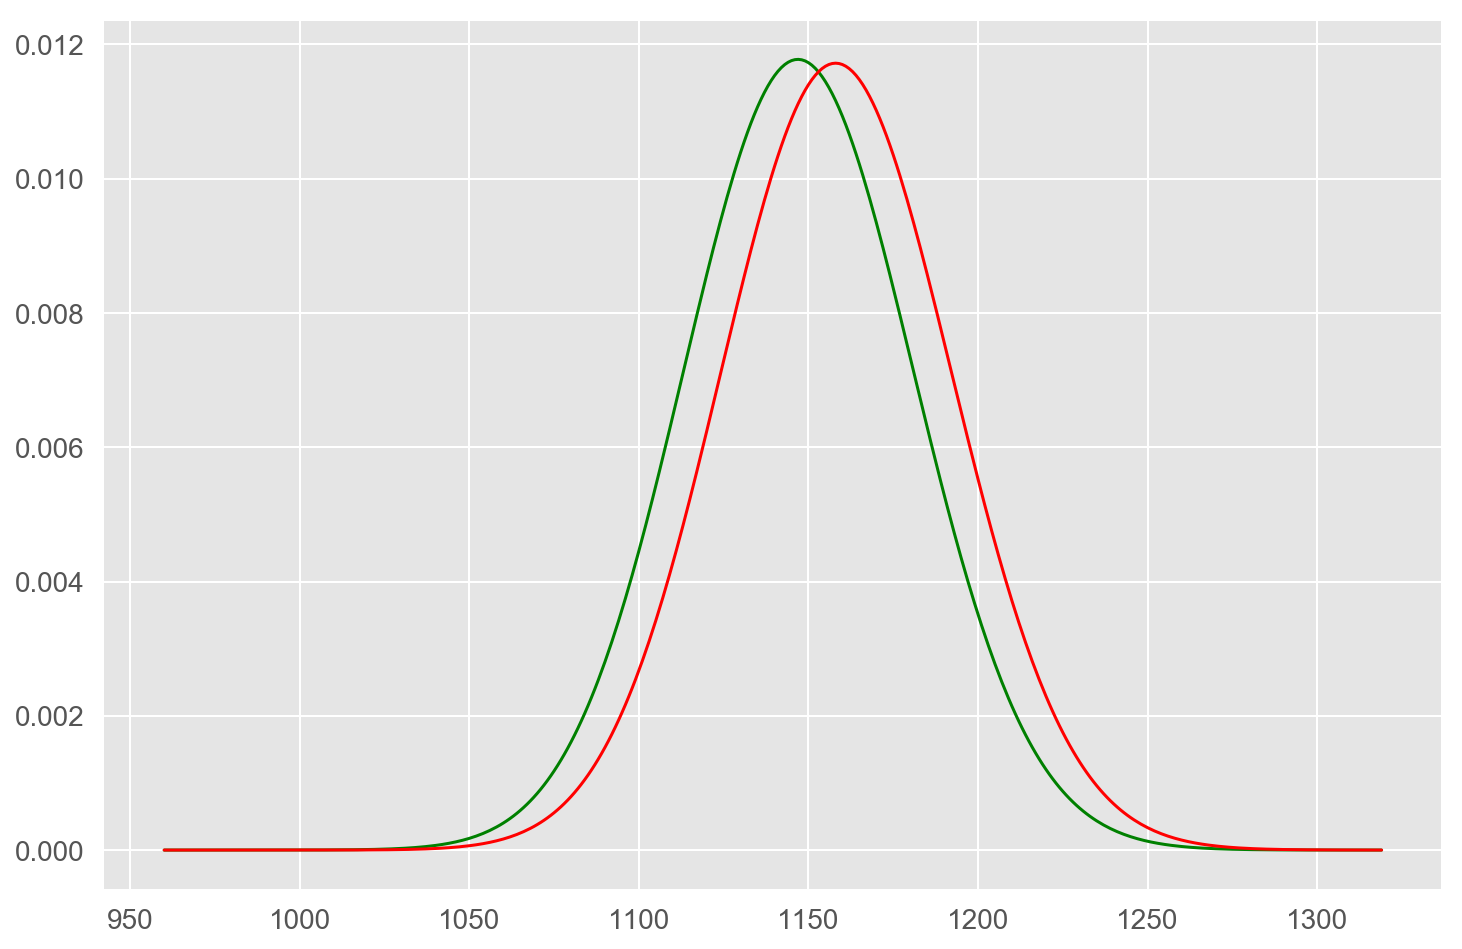

In [70]:
p = poisson.pmf
# poisson = lambda k, mu: mu**k * np.exp(-mu) / factorial(k)

x = np.arange(16*60, 22*60, 1)

mu_goal_for = burned_trace['mu_goal_for'].mean()
y_goal_for = p(x, mu_goal_for)

mu_goal_against = burned_trace['mu_goal_against'].mean()
y_goal_against = p(x, mu_goal_against)

plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{avg})$', color='green')
plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{avg})$', color='red')

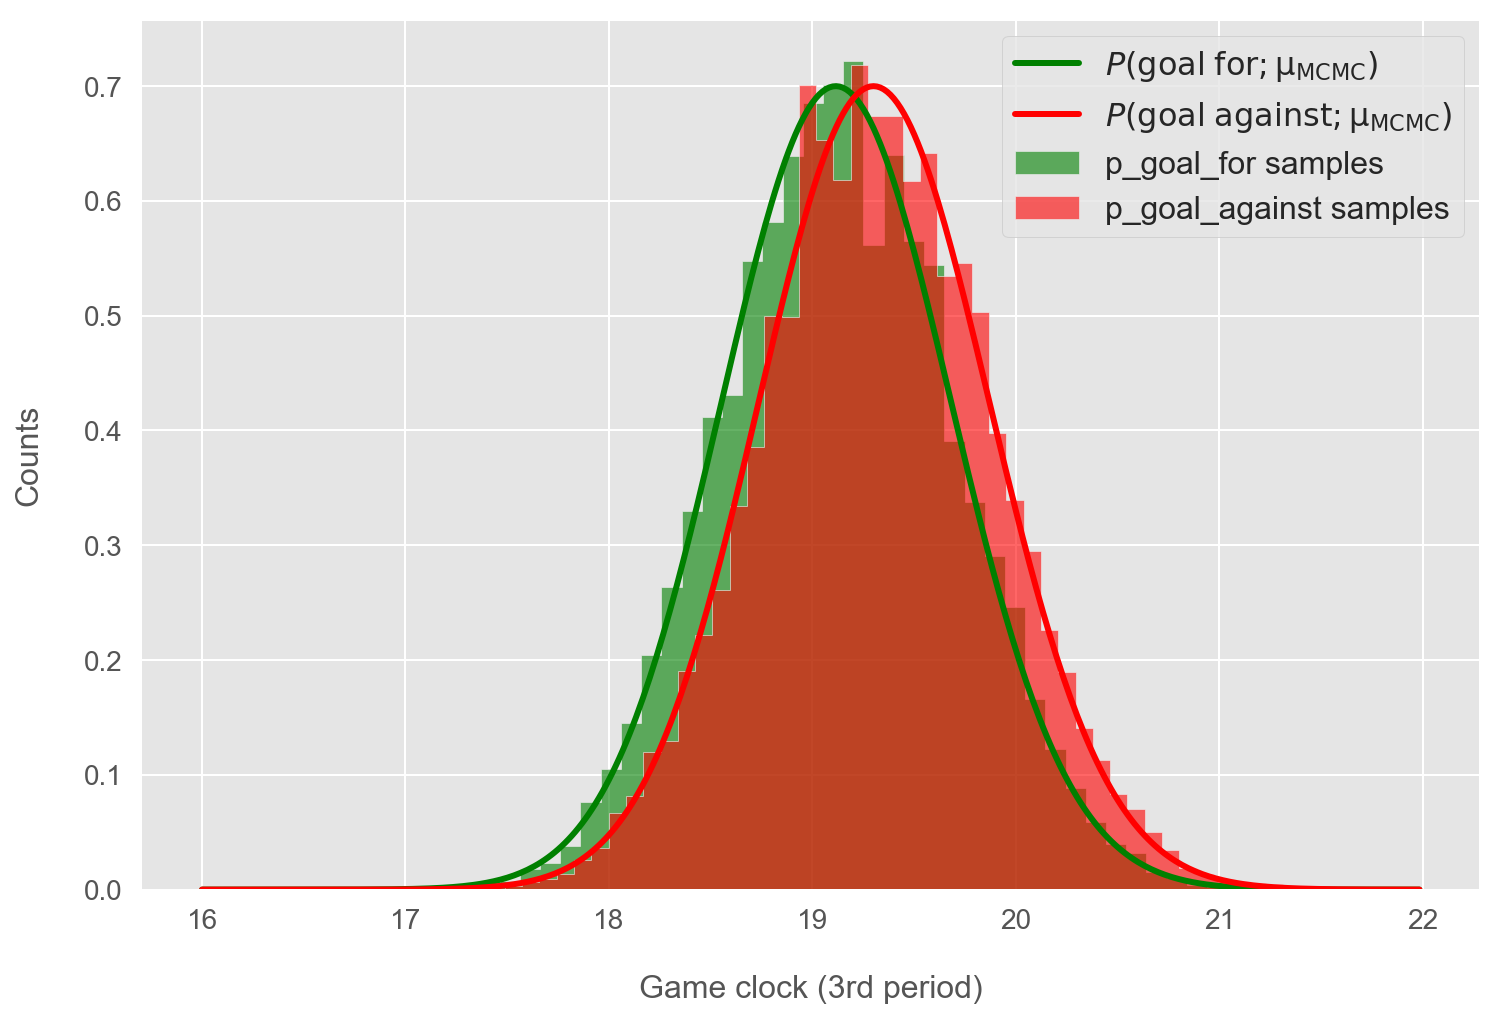

In [72]:
ALPHA = 0.6
LW = 3

# plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
#          color='green', label=r'$P(\rm{goal\;for}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

# plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
#          color='red', label=r'$P(\rm{goal\;against}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

''' Plot the MCMC samples '''

plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
         color='green', label='p_goal_for samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
         color='red', label='p_goal_against samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

''' Plot the poisson distributions '''

p = poisson.pmf
x = np.arange(16*60, 22*60, 1)
mu_goal_for = burned_trace['mu_goal_for'].mean()
mu_goal_against = burned_trace['mu_goal_against'].mean()
y_goal_for = p(x, mu_goal_for)
y_goal_against = p(x, mu_goal_against)

# Convert into minutes and rescale to fit chart
x = x / 60
scale_frac = 0.7
y_goal_for = y_goal_for / y_goal_for.max() * scale_frac
y_goal_against = y_goal_against / y_goal_against.max() * scale_frac

plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{MCMC})$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{MCMC})$', color='red', lw=LW)

plt.ylabel('Counts')
# plt.yticks([])
plt.xlabel('Game clock (3rd period)')
plt.legend();

(Do not include this plot ^ in blog, but re-use source code)

In reality, the probability of an empty net goal should be zero after 20 minutes (since the period is over). We would also need to normalize the probabilities such that   

$
\sum_t \big{[} P(\mathrm{goal\;for}; \mu, t) + P(\mathrm{goal\;against}; \mu, t) + P(\mathrm{game\;end}) \big{]} = 1
$

Since this was just a toy model to get us warmed up with `pymc`, let's just leave this and move on to a more interesting problem.

---

I wonder if we can answer the question: **what are the odds of scoring a goal based on when the goalie is pulled?**

It's probably best to decide that based on the "time since goalie pull" metric and the time remaining in the game. For the chart above, the goal for probability is clearly shifted to the left - however this does not mean that pulling a goalie at the 19 minute mark will have lower odds of a good outcome than pulling at the 18 minute mark. This chart is just a litlihood of scoring given the goalie pull times.

What we should do is label the goalie pull times with the eventual outcome, then model that.

In [73]:
df.columns

Index(['season', 'game_number', 'team_name', 'date', 'pull_period',
       'pull_time', 'goal_for_time', 'goal_against_time', 'goal_for_timedelta',
       'goal_against_timedelta', 'game_end_timedelta'],
      dtype='object')

In [84]:
features = ['pull_time', 'pull_time']
feature_names = ['goal_for', 'goal_against']
masks = [~(df.goal_for_time.isnull()), ~(df.goal_against_time.isnull())]
training_samples = load_training_samples(df, features, masks)

Loaded 270 samples for col pull_time
Loaded 554 samples for col pull_time
Training data shape = (2,)


In [101]:
pm.Deterministic?

In [115]:
def bayes_model(training_samples) -> pm.model.Model:
    """
    Solve for posterior distributions using pymc3
    """
    with pm.Model() as model:

        # Priors for the mu parameter of the poisson distribution
        # Note that mu = mean(Poisson)
        mu_goal_for = pm.Uniform('mu_goal_for', 15*60, 20*60)
        mu_goal_against = pm.Uniform('mu_goal_against', 15*60, 20*60)

        # Observations
        obs_goal_for = pm.Poisson('obs_goal_for', mu_goal_for, observed=training_samples[0])
        obs_goal_against = pm.Poisson('obs_goal_against', mu_goal_against, observed=training_samples[1])
        
        # Priors for the goal probabilities
        p_goal_for = pm.Poisson('p_goal_for', mu_goal_for)
        p_goal_against = pm.Poisson('p_goal_against', mu_goal_against)

        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_goal_against]
>Metropolis: [p_goal_for]
>Metropolis: [mu_goal_against]
>Metropolis: [mu_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:19<00:00, 3735.10draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [116]:
N_burn = 10000
burned_trace = trace[N_burn:]

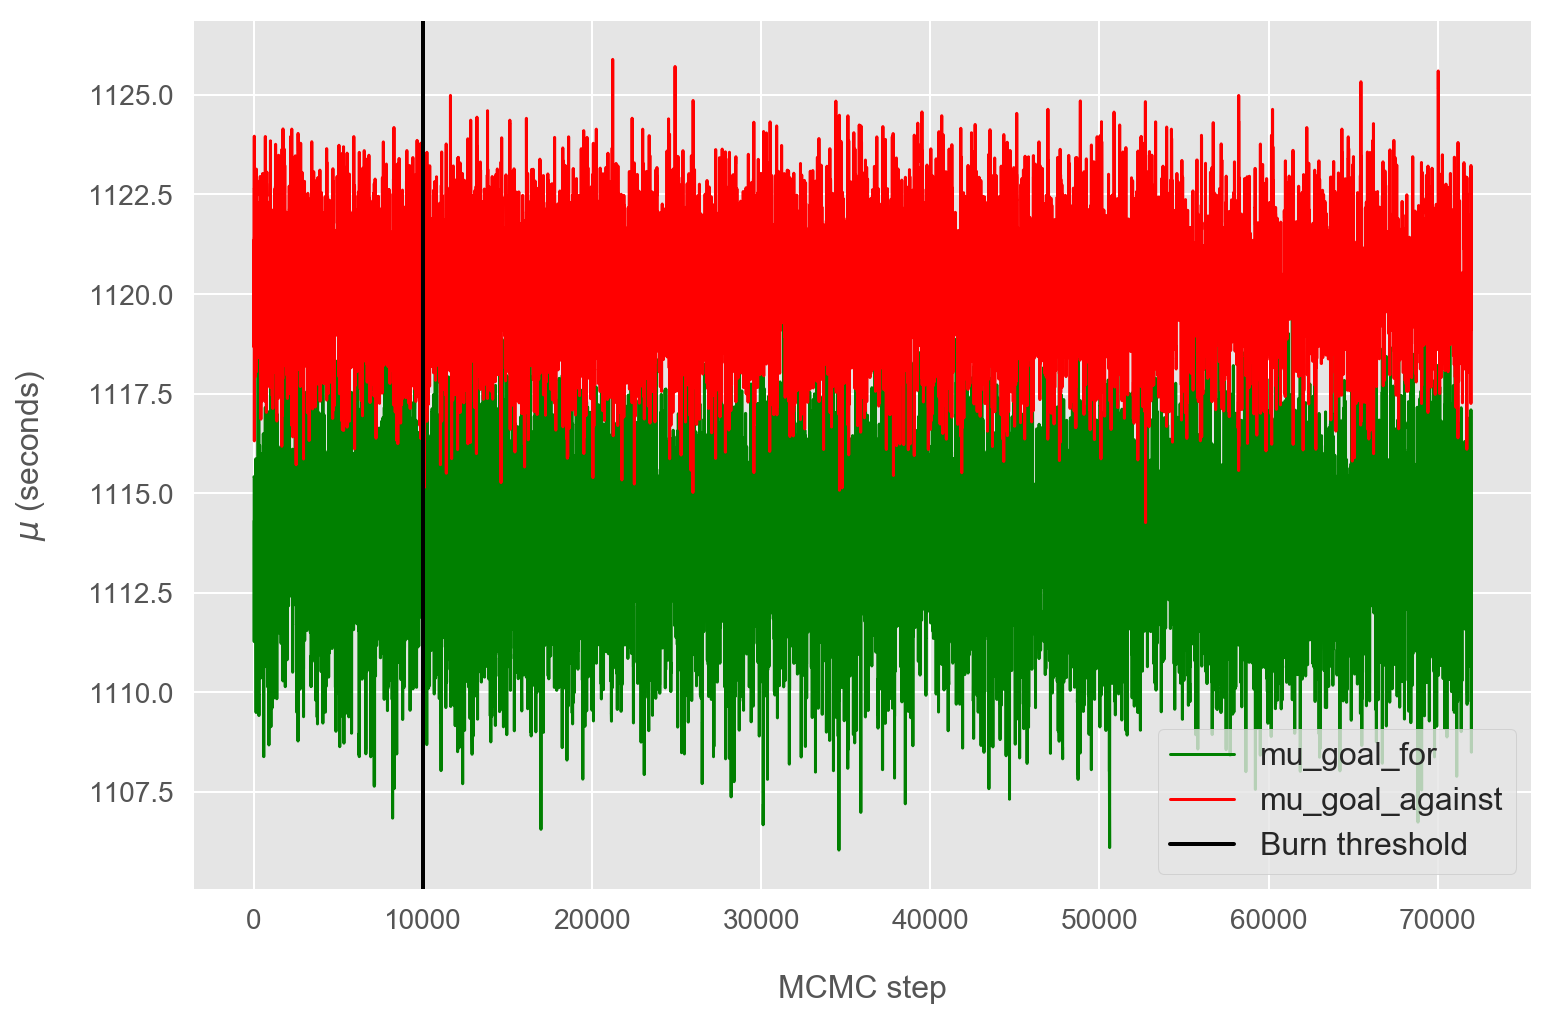

In [117]:
plt.plot(trace['mu_goal_for'], label='mu_goal_for', color='green')
plt.plot(trace['mu_goal_against'], label='mu_goal_against', color='red')
plt.ylabel('$\mu$ (seconds)')
plt.xlabel('MCMC step')

plt.axvline(N_burn, color='black', lw=2, label='Burn threshold')

plt.legend();

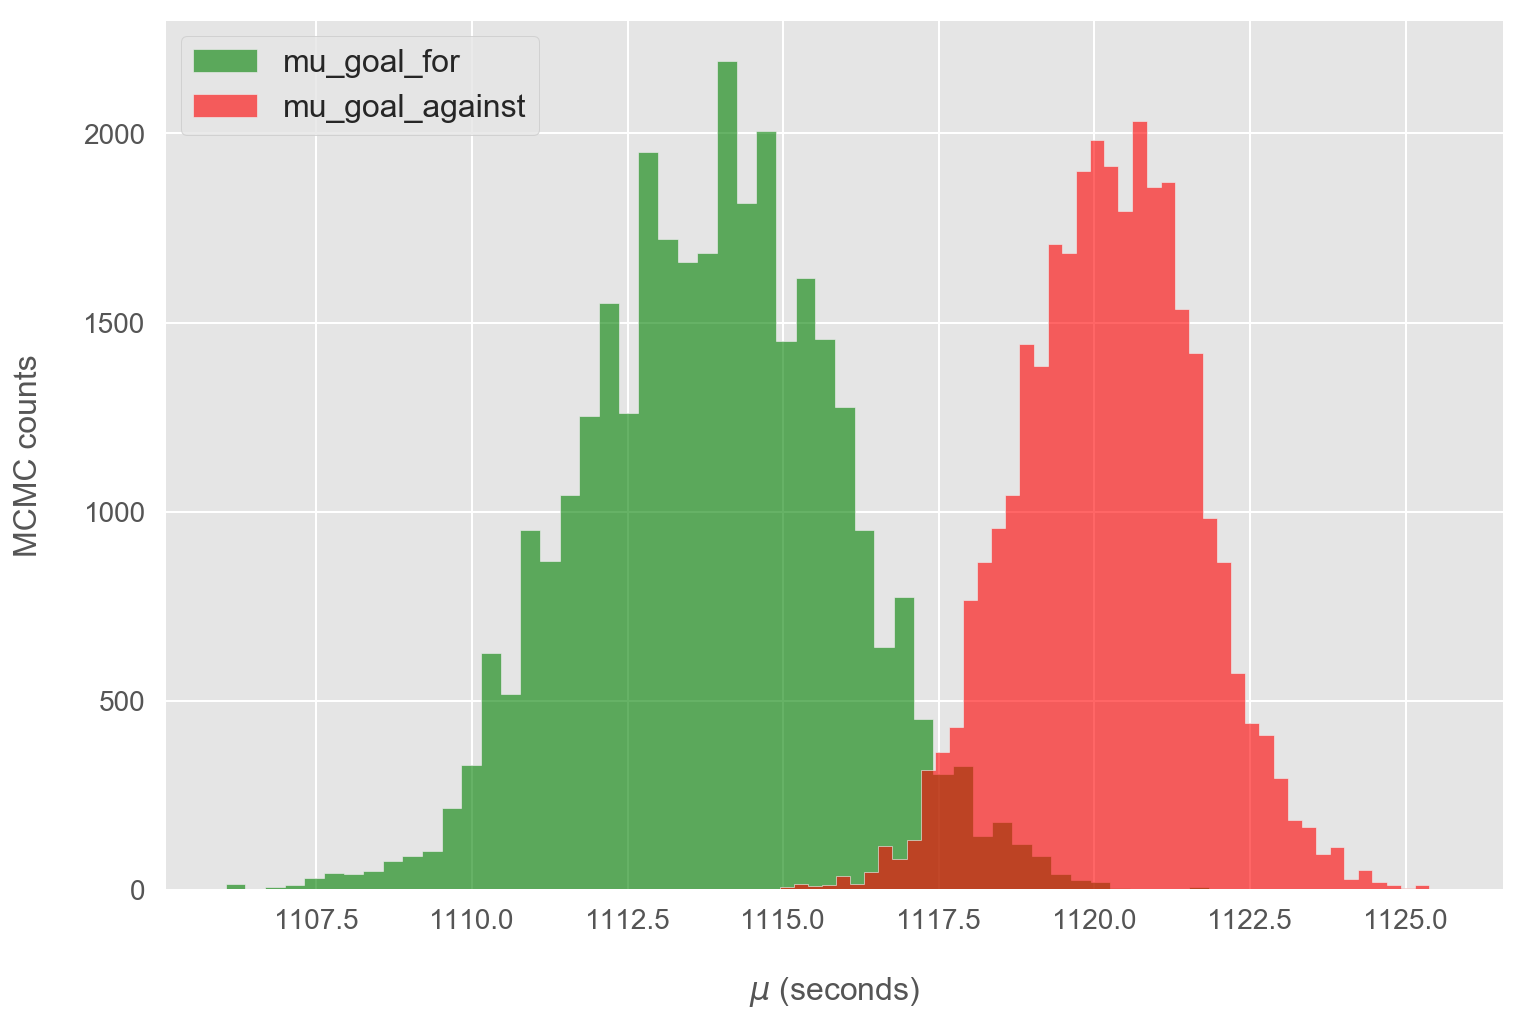

In [118]:
ALPHA = 0.6

plt.hist(burned_trace['mu_goal_for'], bins=50,
         color='green', label='mu_goal_for',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_goal_against'], bins=50,
         color='red', label='mu_goal_against',
         histtype='stepfilled', alpha=ALPHA)
plt.ylabel('MCMC counts')
plt.xlabel('$\mu$ (seconds)')
plt.legend();

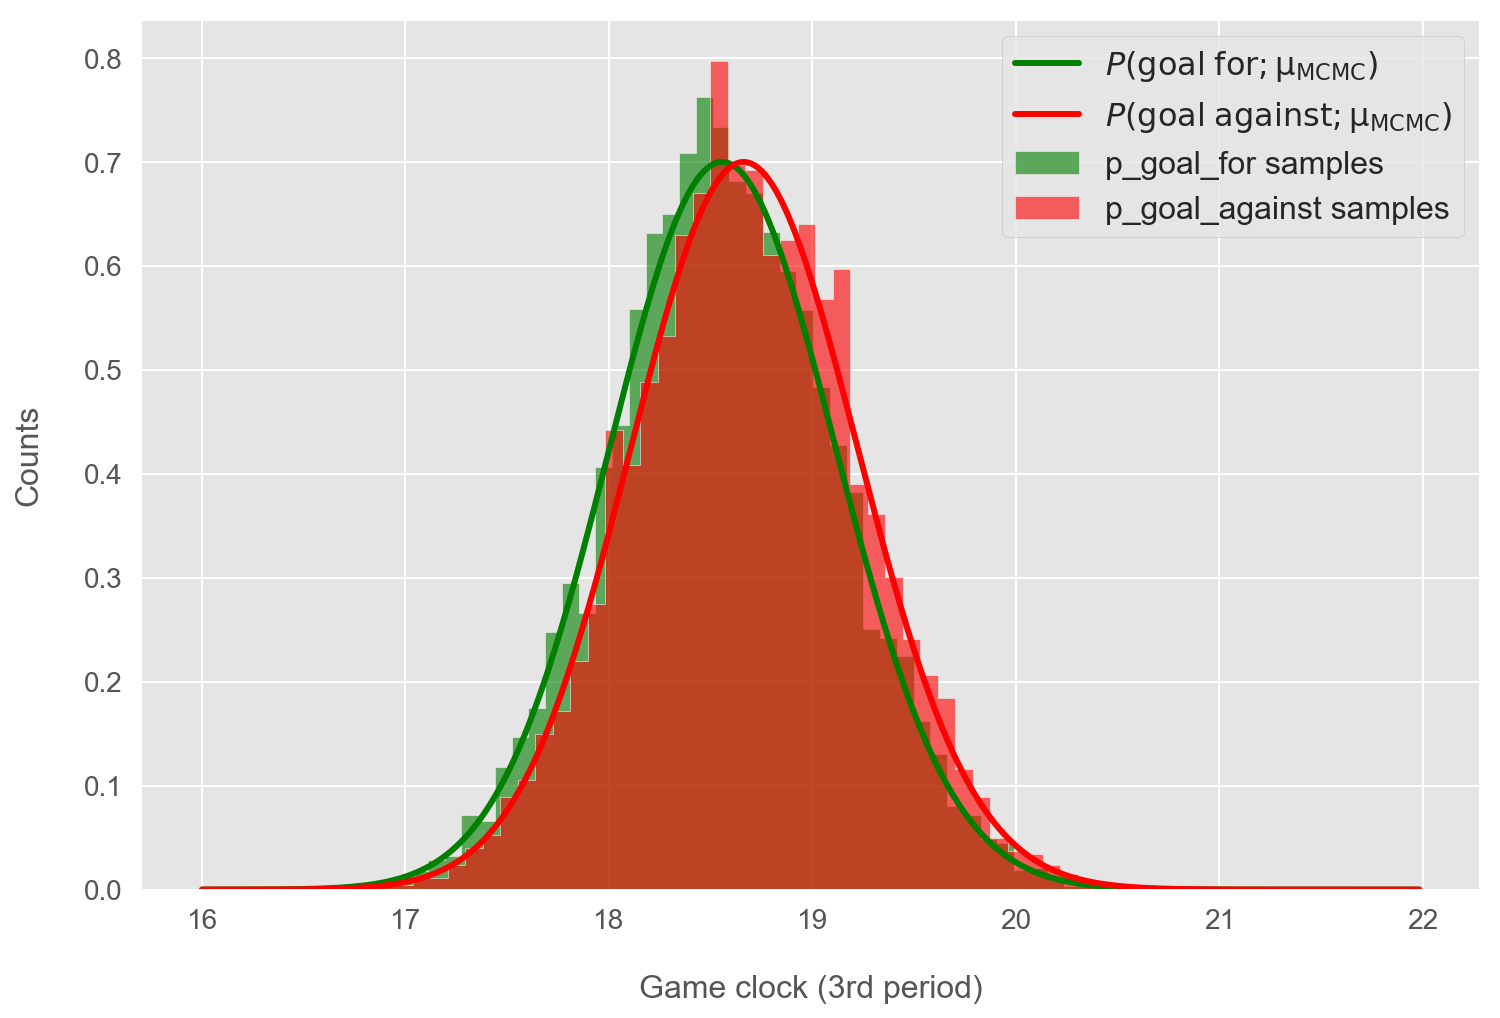

In [119]:
ALPHA = 0.6
LW = 3

# plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
#          color='green', label=r'$P(\rm{goal\;for}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

# plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
#          color='red', label=r'$P(\rm{goal\;against}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

''' Plot the MCMC samples '''

plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
         color='green', label='p_goal_for samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
         color='red', label='p_goal_against samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

''' Plot the poisson distributions '''

p = poisson.pmf
x = np.arange(16*60, 22*60, 1)
mu_goal_for = burned_trace['mu_goal_for'].mean()
mu_goal_against = burned_trace['mu_goal_against'].mean()
y_goal_for = p(x, mu_goal_for)
y_goal_against = p(x, mu_goal_against)

# Convert into minutes and rescale to fit chart
x = x / 60
scale_frac = 0.7
y_goal_for = y_goal_for / y_goal_for.max() * scale_frac
y_goal_against = y_goal_against / y_goal_against.max() * scale_frac

plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{MCMC})$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{MCMC})$', color='red', lw=LW)

plt.ylabel('Counts')
# plt.yticks([])
plt.xlabel('Game clock (3rd period)')
plt.legend();

Let's test this with a uniform prior

In [170]:
def bayes_model(training_samples) -> pm.model.Model:
    """
    Solve for posterior distributions using pymc3
    """
    with pm.Model() as model:

        # Priors for the goal probabilties
        # Last 5 minutes of the game, in seconds
#         p_goal_for = pm.Uniform('p_goal_for', 15*60, 20*60)
#         p_goal_against = pm.Uniform('p_goal_against', 15*60, 20*60)

        # Priors for the mu parameter of the poisson distribution
        # Note that mu = mean(Poisson)
        mu_goal_for = pm.Uniform('mu_goal_for', 15*60, 20*60)
        mu_goal_against = pm.Uniform('mu_goal_against', 15*60, 20*60)
        
        # Observations
        obs_goal_for = pm.Poisson(
            'obs_goal_for',
            mu=mu_goal_for,
            observed=training_samples[0],
        )
        obs_goal_against = pm.Poisson(
            'obs_goal_against',
            mu=mu_goal_against,
            observed=training_samples[1],
        )
        
        p_goal_for = pm.Deterministic(
            'p_goal_for', pm.Poisson('posterior_for', mu_goal_for)
        )
        p_goal_against = pm.Deterministic(
            'p_goal_against', pm.Poisson('posterior_against', mu_goal_against)
        )

        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [posterior_against]
>Metropolis: [posterior_for]
>Metropolis: [mu_goal_against]
>Metropolis: [mu_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:19<00:00, 3787.87draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [171]:
N_burn = 10000
burned_trace = trace[N_burn:]


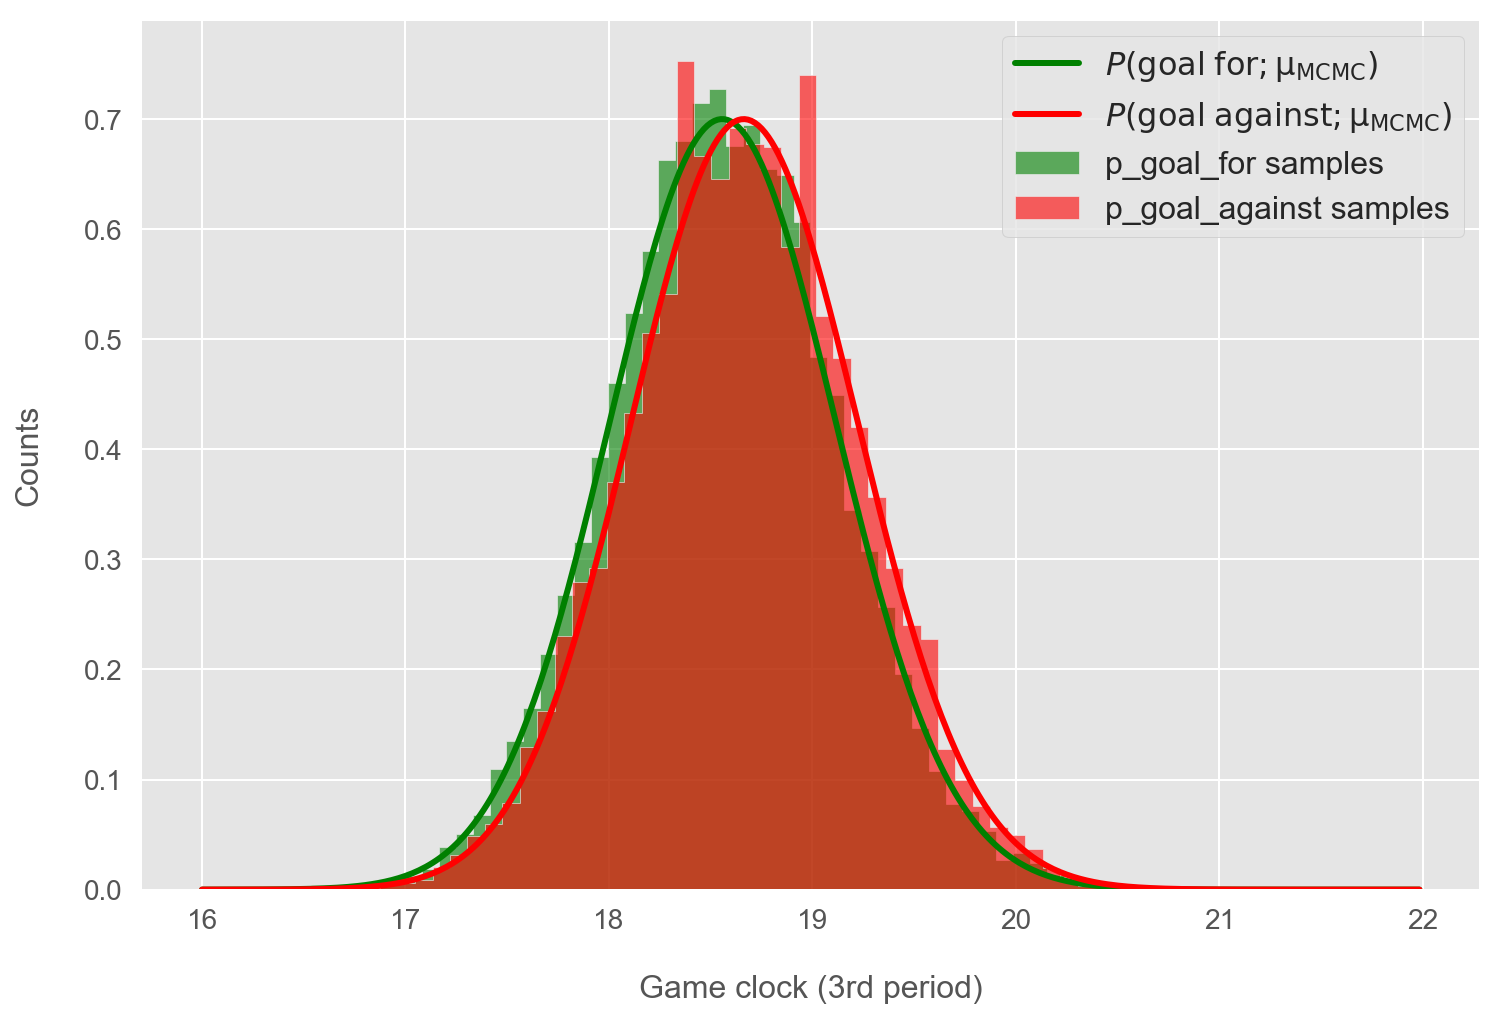

In [174]:
ALPHA = 0.6
LW = 3

# plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
#          color='green', label=r'$P(\rm{goal\;for}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

# plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
#          color='red', label=r'$P(\rm{goal\;against}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

''' Plot the MCMC samples '''

plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
         color='green', label='p_goal_for samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
         color='red', label='p_goal_against samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

''' Plot the poisson distributions '''

p = poisson.pmf
x = np.arange(16*60, 22*60, 1)
mu_goal_for = burned_trace['mu_goal_for'].mean()
mu_goal_against = burned_trace['mu_goal_against'].mean()
y_goal_for = p(x, mu_goal_for)
y_goal_against = p(x, mu_goal_against)

# Convert into minutes and rescale to fit chart
x = x / 60
scale_frac = 0.7
y_goal_for = y_goal_for / y_goal_for.max() * scale_frac
y_goal_against = y_goal_against / y_goal_against.max() * scale_frac

plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{MCMC})$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{MCMC})$', color='red', lw=LW)

plt.ylabel('Counts')
# plt.yticks([])
plt.xlabel('Game clock (3rd period)')
plt.legend();
plt.show()

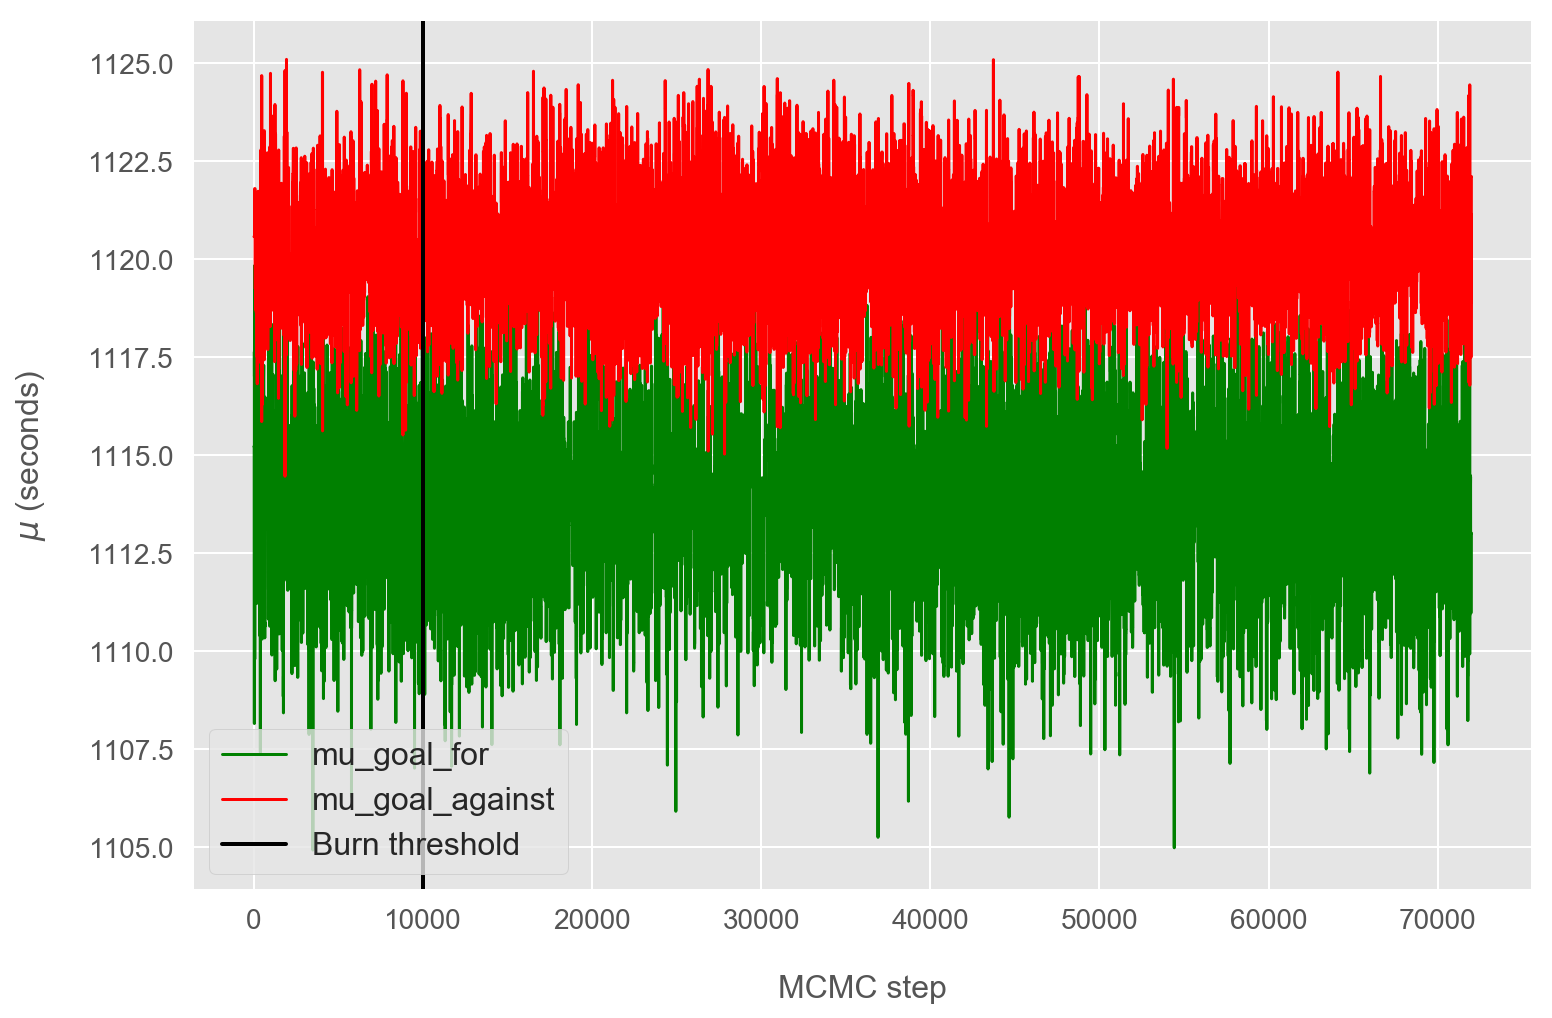

In [175]:
plt.plot(trace['mu_goal_for'], label='mu_goal_for', color='green')
plt.plot(trace['mu_goal_against'], label='mu_goal_against', color='red')
plt.ylabel('$\mu$ (seconds)')
plt.xlabel('MCMC step')

plt.axvline(N_burn, color='black', lw=2, label='Burn threshold')

plt.legend();

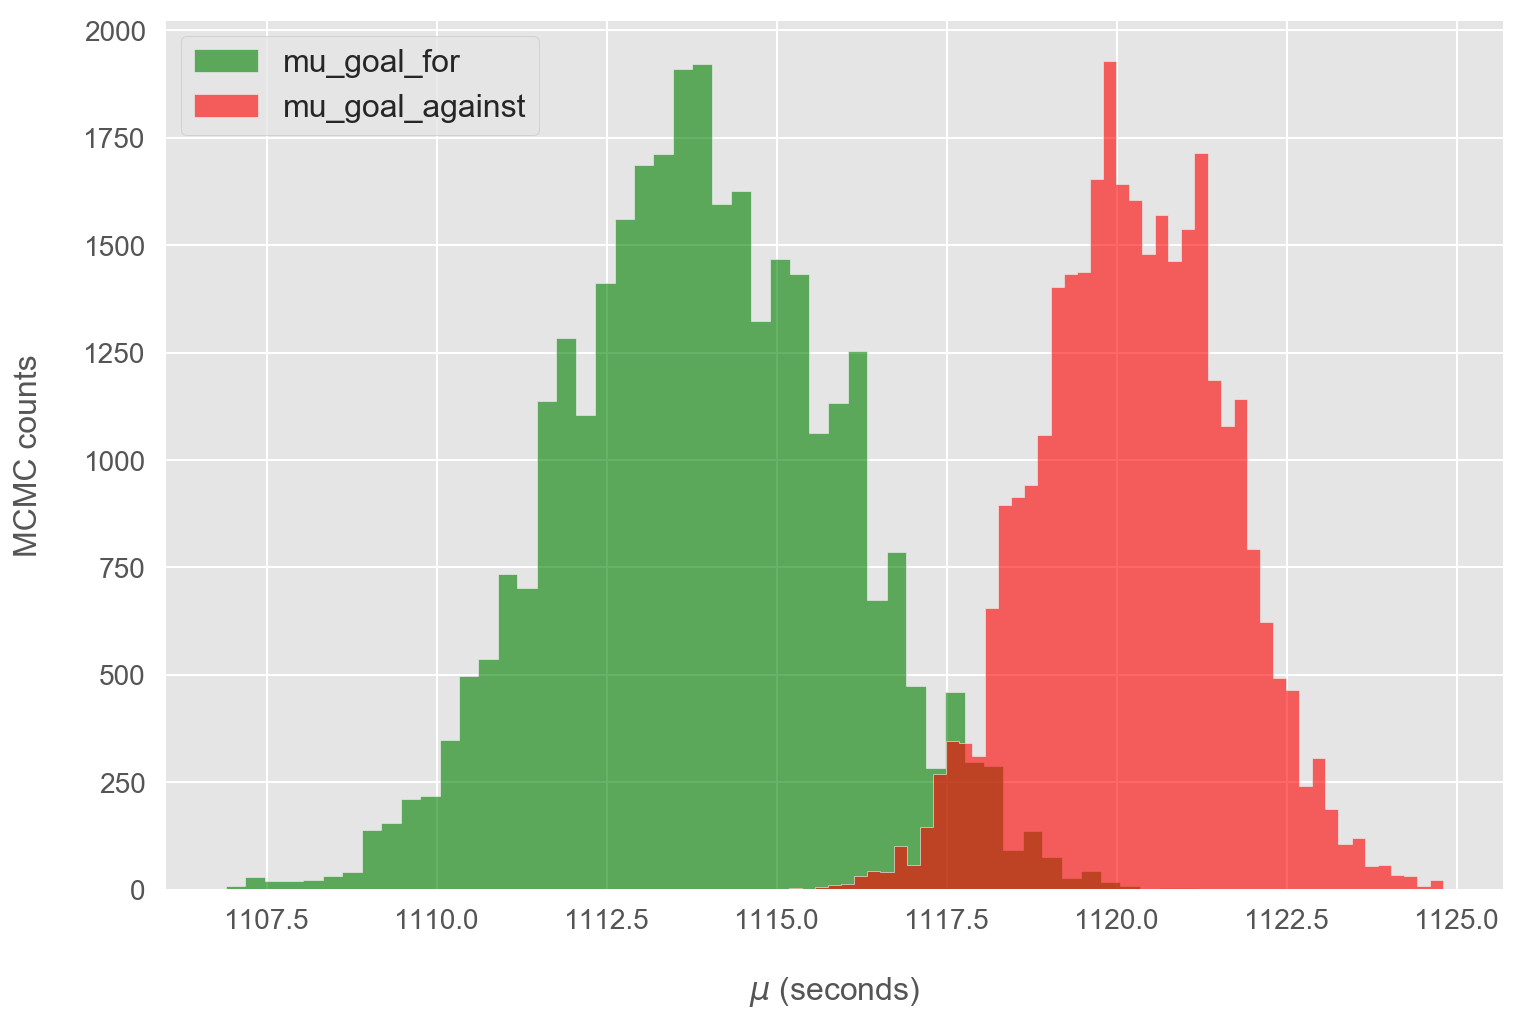

In [176]:
ALPHA = 0.6

plt.hist(burned_trace['mu_goal_for'], bins=50,
         color='green', label='mu_goal_for',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_goal_against'], bins=50,
         color='red', label='mu_goal_against',
         histtype='stepfilled', alpha=ALPHA)
plt.ylabel('MCMC counts')
plt.xlabel('$\mu$ (seconds)')
plt.legend();

In [163]:
burned_trace.varnames

['p_goal_for_interval__',
 'p_goal_against_interval__',
 'mu_goal_for_interval__',
 'mu_goal_against_interval__',
 'p_goal_for',
 'p_goal_against',
 'mu_goal_for',
 'mu_goal_against']

In [147]:
def bayes_model(training_samples) -> pm.model.Model:
    """
    Solve for posterior distributions using pymc3
    """
    with pm.Modelm() as model:

        # Observations to train the model
#         obs_goal_for = pm.Poisson(
#             'obs_goal_for',
#             mu=training_samples[0].mean(),
#             observed=training_samples[0],
#         )
#         obs_goal_against = pm.Poisson(
#             'obs_goal_against',
#             mu=training_samples[1].mean(),
#             observed=training_samples[1],
#         )
        
        # Priors for the mu parameter of the
        # Poisson distribution.
        # Note that mu = mean(Poisson)
        mu_goal_for = pm.Uniform(
            'mu_goal_for', 15*60, 20*60
        )
        mu_goal_against = pm.Uniform(
            'mu_goal_against', 15*60, 20*60
        )
        
        # Goal probabilities
        p_goal_for = pm.Poisson(
            'p_goal_for', mu_goal_for, observed=training_samples[0]
        )
        p_goal_against = pm.Poisson(
            'p_goal_against', mu_goal_against, observed=training_samples[1]
        )

        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu_goal_against]
>Metropolis: [mu_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:12<00:00, 5871.29draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [152]:
N_burn = 10000
burned_trace = trace[N_burn:]

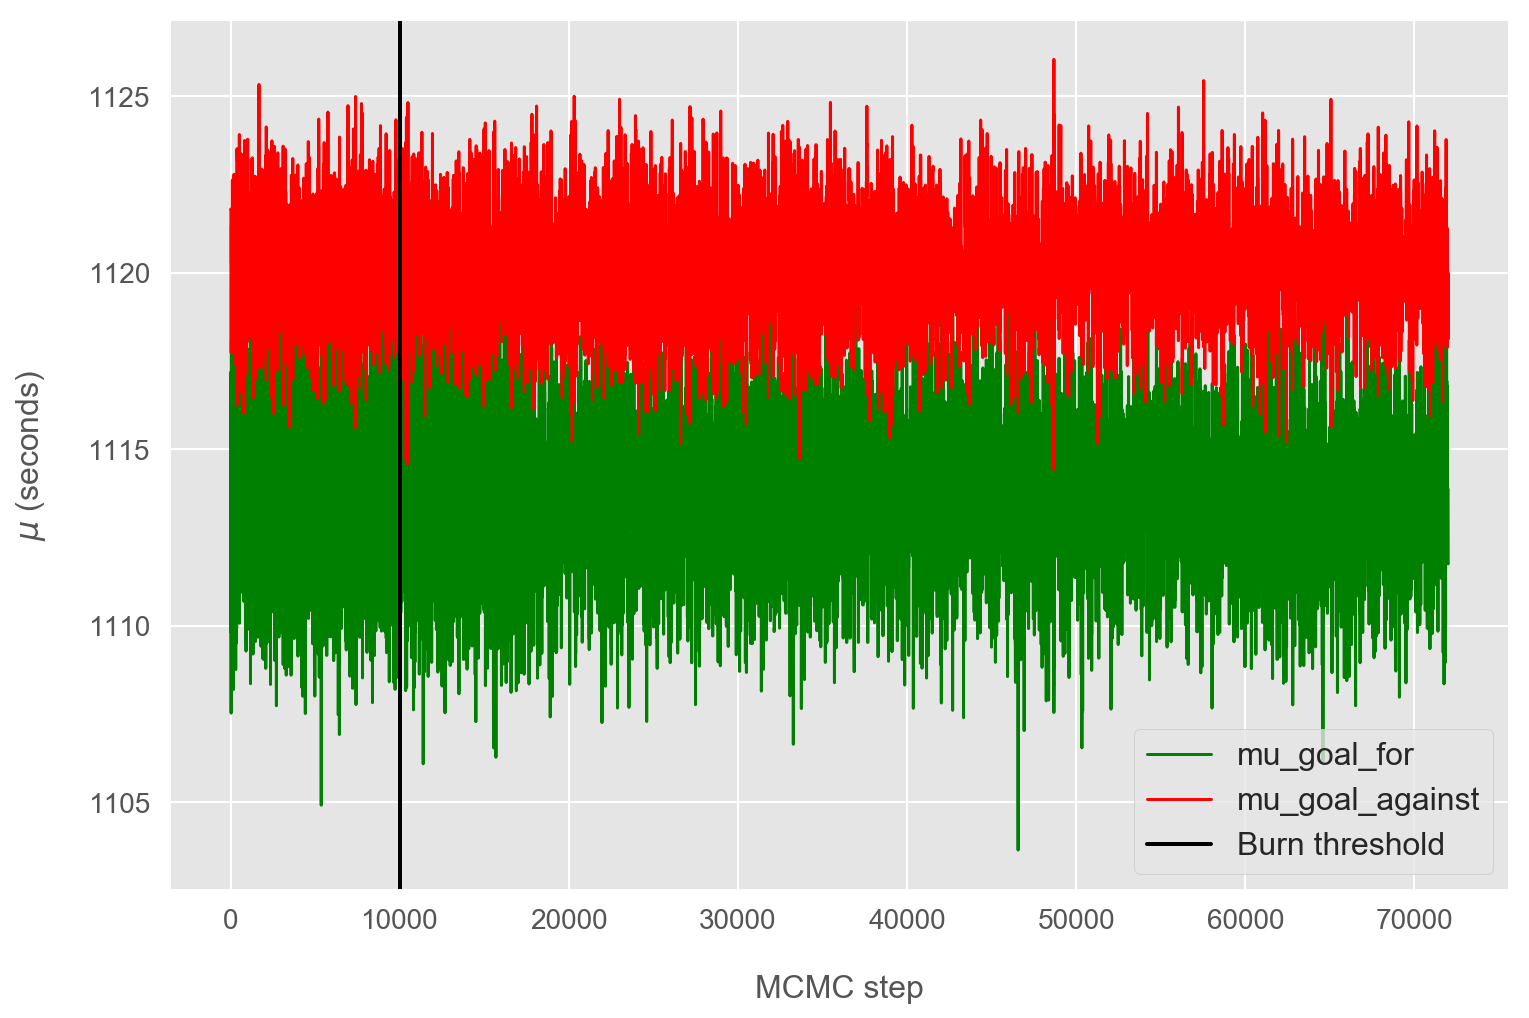

In [153]:
plt.plot(trace['mu_goal_for'], label='mu_goal_for', color='green')
plt.plot(trace['mu_goal_against'], label='mu_goal_against', color='red')
plt.ylabel('$\mu$ (seconds)')
plt.xlabel('MCMC step')

plt.axvline(N_burn, color='black', lw=2, label='Burn threshold')

plt.legend();

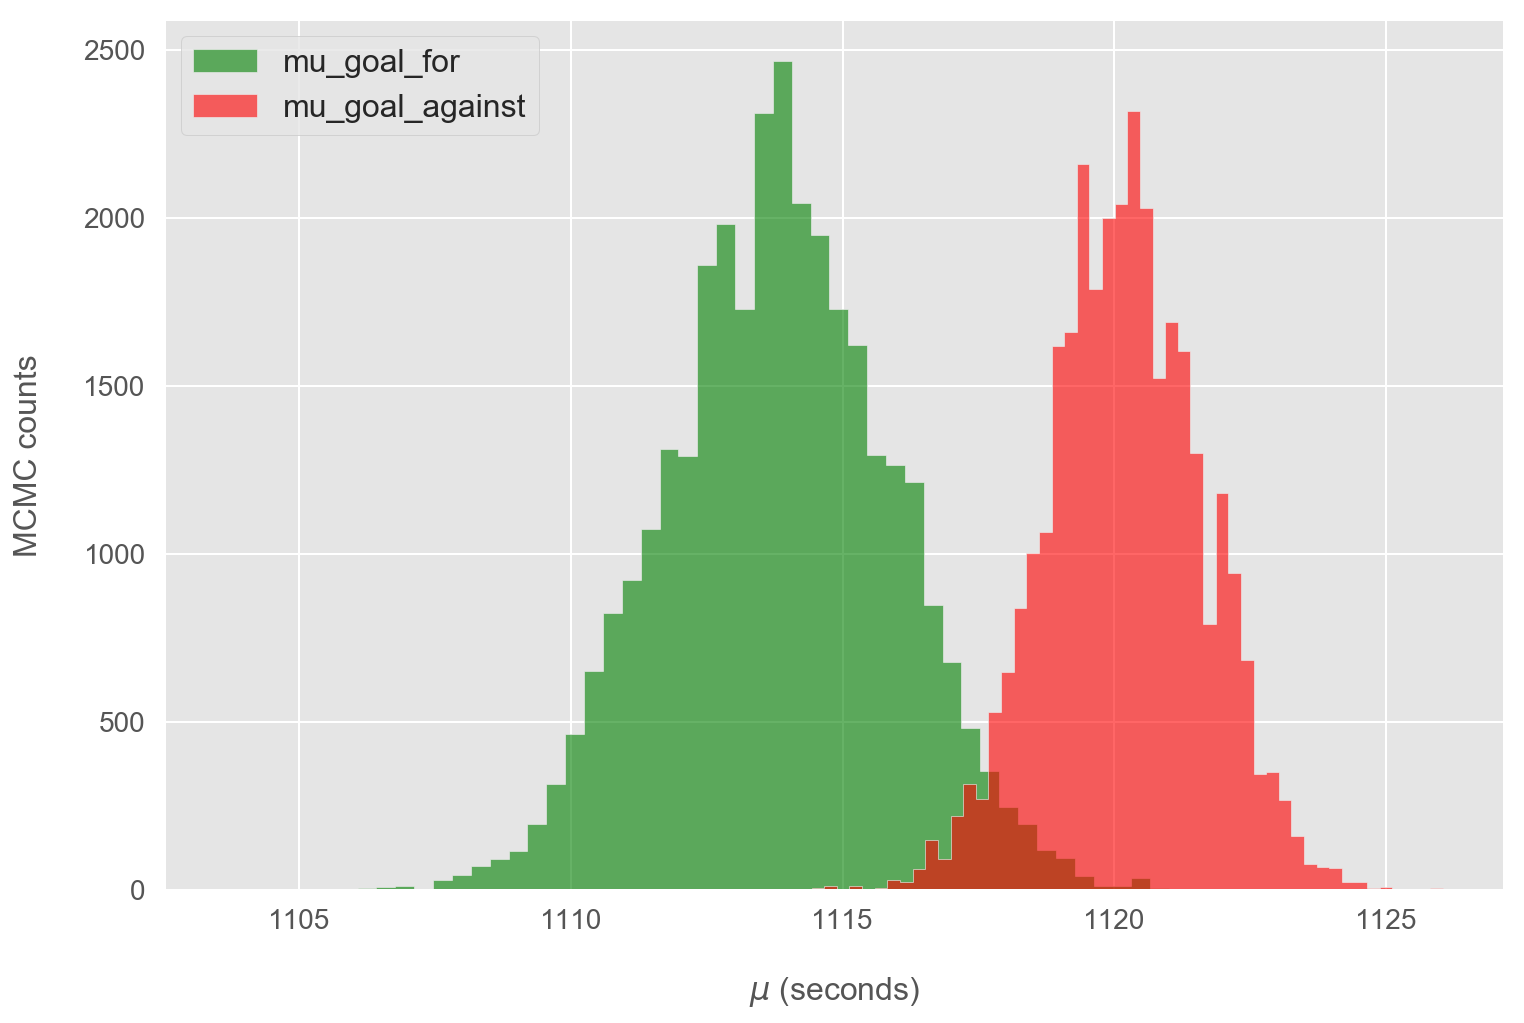

In [154]:
ALPHA = 0.6

plt.hist(burned_trace['mu_goal_for'], bins=50,
         color='green', label='mu_goal_for',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_goal_against'], bins=50,
         color='red', label='mu_goal_against',
         histtype='stepfilled', alpha=ALPHA)
plt.ylabel('MCMC counts')
plt.xlabel('$\mu$ (seconds)')
plt.legend();

---

Let's focus on our original question

What is the **risk reward of pulling a goalie as a function of:**
 - ~~**t = Time remaining in the game.** For instance, if there's 3 minutes left, what is the chance that pulling the goalie will result in a goal for? What is the probability it will result in a goal against?~~
 - **t = Time since goalie pull.** For instance, after the goalie has been pulled for 1 minute, what is the chance of seeing a goal for or goal against?

#### Hypothesis (A/B) testing example

In [103]:
from scipy import stats

In [104]:
#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")


Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [106]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:14<00:00, 5790.58draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [107]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

One way of calculating the probability

In [110]:
(p_A_samples > p_B_samples).sum() / p_A_samples.shape[0]

0.25855263157894737

In [111]:
(p_B_samples > p_A_samples).sum() / p_A_samples.shape[0]

0.7414473684210526

An equivalent way

In [113]:
(delta_samples > 0).sum() / delta_samples.shape[0]

0.25855263157894737

In [114]:
(delta_samples < 0).sum() / delta_samples.shape[0]

0.7414473684210526